In [ ]:
%load_ext autoreload
%autoreload 2

In [1]:
import torch
import numpy as np
import functools
import matplotlib.pyplot as plt
import tqdm

In [2]:
signal_to_noise_ratio = 0.3
num_steps = 500
device = torch.device('cuda:3')

# Sampling

In [3]:
def marginal_prob_std(t, sigma):
    t = torch.tensor(t, device=device)
    return torch.sqrt((sigma**(2*t) - 1.) / 2. / np.log(sigma))

def diffusion_coeff(t, sigma):
    return torch.tensor(sigma**t, device=device)

sigma = 30.0
marginal_prob_std_fn = functools.partial(marginal_prob_std, sigma=sigma)
diffusion_coeff_fn = functools.partial(diffusion_coeff, sigma=sigma)

In [6]:
def pc_sampler(score_model,
               marginal_prob_std,
               diffusion_coeff,
               batch_size=32,
               num_steps=num_steps,
               device=device,
               snr=signal_to_noise_ratio,
               eps=1e-3,):
  
  score_model.eval()

  t = torch.ones(batch_size, device=device)
  init_x = torch.randn(batch_size, 3, 512, device=device) * marginal_prob_std(t)[:, None, None]
  time_steps = np.linspace(1., eps, num_steps)
  step_size = time_steps[0] - time_steps[1]
  x = init_x
  
  with torch.no_grad():
    
    for time_step in tqdm.notebook.tqdm(time_steps):      
      batch_time_step = torch.ones(batch_size, device=device) * time_step
      # Corrector step (Langevin MCMC)
      grad = score_model(x, batch_time_step)
      grad_norm = torch.norm(grad.reshape(grad.shape[0], -1), dim=-1).mean()
      noise_norm = np.sqrt(np.prod(x.shape[1:]))
      langevin_step_size = 2 * (snr * noise_norm / grad_norm)**2
      x = x + langevin_step_size * grad + torch.sqrt(2 * langevin_step_size) * torch.randn_like(x)      

      # Predictor step (Euler-Maruyama)
      g = diffusion_coeff(batch_time_step)
      x_mean = x + (g**2)[:, None, None] * score_model(x, batch_time_step) * step_size
      x = x_mean + torch.sqrt(g**2 * step_size)[:, None, None] * torch.randn_like(x)      
    
    # The last step does not include any noise
    return x_mean

In [8]:
# sampling
from model import DW4BSS, DiffWave3
from GAU import DW4BSS_GAU, GAUnet3
from params import gau_params

net = DW4BSS_GAU(gau_params, marginal_prob_std_fn).to(device)
try:
    ckpt = torch.load(r'/home/wyl/projects/_EEG_score/ckpt/GAU_ckpt_1.pth')
    net.load_state_dict(ckpt, strict=False)
    print('model loaded')
except:
    print('wrong checkpoint')

sample_batch_size = 64
sampler = pc_sampler

samples = sampler(net,
                  marginal_prob_std_fn,
                  diffusion_coeff_fn,
                  sample_batch_size,
                  device=device)

generated_data = torch.tensor(samples).cpu()
path = r'/home/wyl/projects/_EEG_score/result/generated.npy'
np.save(path, generated_data)

model loaded


/tmp/ipykernel_3330811/3532968405.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  t = torch.tensor(t, device=device)


  0%|          | 0/500 [00:00<?, ?it/s]

/tmp/ipykernel_3330811/3532968405.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(sigma**t, device=device)
/tmp/ipykernel_3330811/2860015320.py:22: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  generated_data = torch.tensor(samples).cpu()


# Show

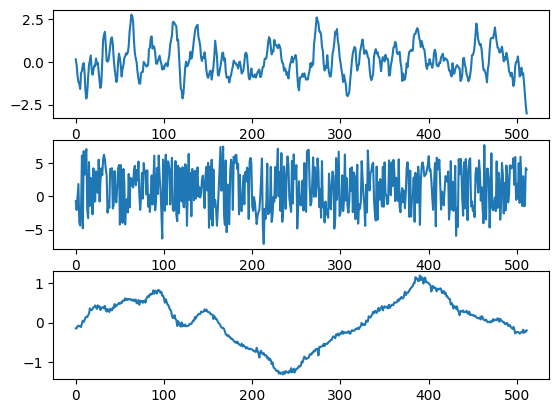

In [11]:
import matplotlib.pyplot as plt

path = r'/home/wyl/projects/_EEG_score/result/generated.npy'
sample = np.load(path)
a_group = sample[0]


# Eval

Text(0, 0.5, 'spectral intensity')

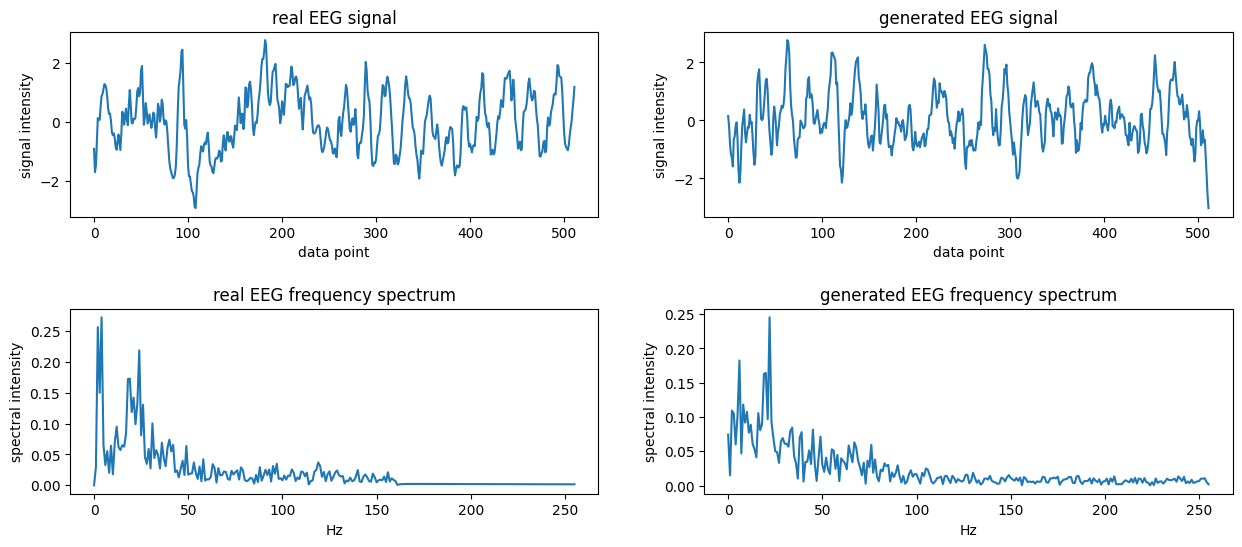

In [39]:
# fft plot
import numpy as np
from utils import my_fft
import matplotlib.pyplot as plt

# real data
data_path = r'/home/wyl/projects/_EEG_score/data/separated_data/combined.npy'
get_data = np.load(data_path)

data = get_data.squeeze(1)[0][0]
data1 = get_data.squeeze(1)[0][1]
data2 = get_data.squeeze(1)[0][2]

xf, yf = my_fft(data)
xf1, yf1 = my_fft(a_group[0])

# plt.figure(0)
# plt.plot(data)
# plt.xlabel('1')
# plt.ylabel('2')
# plt.title('3')
# plt.show()

# plt.figure(1)
# plt.plot(xf, yf)
# plt.xlabel('1')
# plt.ylabel('2')
# plt.title('3')
# plt.show()

# plt.figure(2)
# plt.plot(a_group[0])
# plt.xlabel('1')
# plt.ylabel('2')
# plt.title('3')
# plt.show()

# plt.figure(3)
# plt.plot(xf1, yf1)
# plt.xlabel('1')
# plt.ylabel('2')
# plt.title('3')
# plt.show()

fig, axs = plt.subplots(2, 2, figsize=(15, 6))
plt.subplots_adjust(wspace=0.2, hspace=0.5)

axs[0, 0].set_title('real EEG signal')
axs[0, 1].set_title('generated EEG signal')
axs[1, 0].set_title('real EEG frequency spectrum')
axs[1, 1].set_title('generated EEG frequency spectrum')

axs[0, 0].plot(data)
axs[0, 1].plot(a_group[0])
axs[1, 0].plot(xf, yf)
axs[1, 1].plot(xf1, yf1)

axs[0, 0].set_xlabel('data point')
axs[0, 0].set_ylabel('signal intensity')
axs[0, 1].set_xlabel('data point')
axs[0, 1].set_ylabel('signal intensity')
axs[1, 0].set_xlabel('Hz')
axs[1, 0].set_ylabel('spectral intensity')
axs[1, 1].set_xlabel('Hz')
axs[1, 1].set_ylabel('spectral intensity')

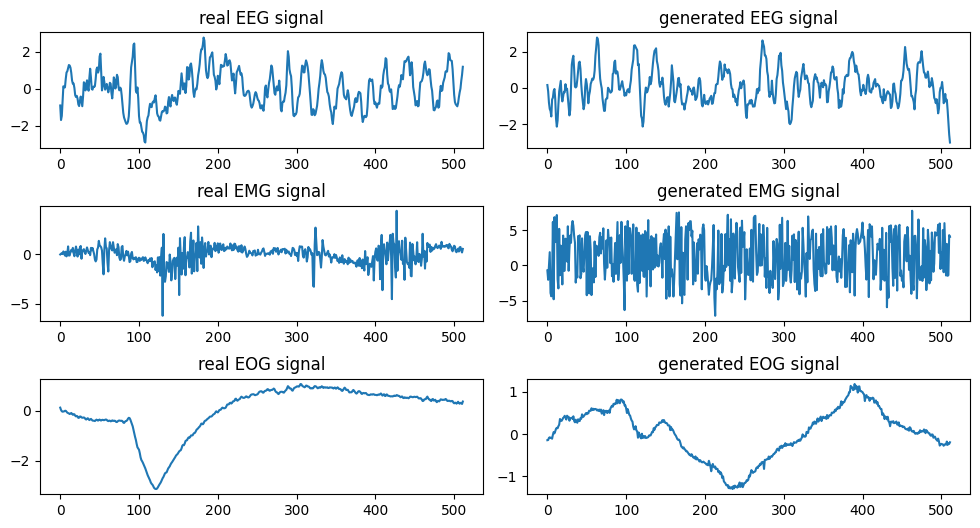

In [37]:


fig, axs = plt.subplots(ncols=2, nrows=3, figsize=(12, 6))
plt.subplots_adjust(wspace=0.1, hspace=0.5)

axs[0, 1].plot(a_group[0])
axs[0, 1].set_title('generated EEG signal')
axs[1,1].plot(a_group[1])
axs[1,1].set_title('generated EMG signal')
axs[2,1].plot(a_group[2])
axs[2,1].set_title('generated EOG signal')

axs[0,0].plot(data)
axs[0,0].set_title('real EEG signal')
axs[1,0].plot(data1)
axs[1,0].set_title('real EMG signal')
axs[2,0].plot(data2)
axs[2,0].set_title('real EOG signal')

fig.show()